In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [17]:
# Import the `RandomForestClassifier`
from sklearn.ensemble import RandomForestClassifier

In [2]:
directory = 'UCI HAR Dataset/train/X_train.txt'
sub_dir = 'UCI HAR Dataset/train/subject_train.txt'
y_dir = 'UCI HAR Dataset/train/y_train.txt'
train = np.loadtxt(directory)
train_subject = np.loadtxt(sub_dir)
train_y = np.loadtxt(y_dir)

In [3]:
directory = 'UCI HAR Dataset/test/X_test.txt'
sub_dir = 'UCI HAR Dataset/test/subject_test.txt'
y_dir = 'UCI HAR Dataset/test/y_test.txt'
test = np.loadtxt(directory)
test_subject = np.loadtxt(sub_dir)
test_y = np.loadtxt(y_dir)

Optimal number of features : 221


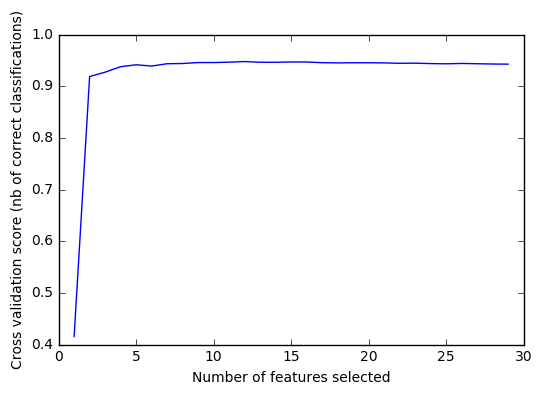

In [57]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                           n_redundant=2, n_repeated=0, n_classes=8,
#                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=20, cv=KFold(10),
              scoring='accuracy')
rfecv.fit(train, train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [58]:
rfecv.grid_scores_

array([ 0.41524604,  0.91866681,  0.92709775,  0.9377124 ,  0.94138106,
        0.9389319 ,  0.94342003,  0.94382856,  0.94573222,  0.94573203,
        0.94641101,  0.94763531,  0.9462757 ,  0.94627606,  0.9468201 ,
        0.94681973,  0.94545955,  0.94505157,  0.94532313,  0.94532313,
        0.94505176,  0.94423543,  0.94450773,  0.94369159,  0.94328324,
        0.94396332,  0.94341929,  0.9428747 ,  0.9426026 ])

In [59]:
#retrieve feature index in the original training dataset
features = []
for i in range(len(rfecv.support_)):
    if rfecv.support_[i]:
        features.append(i)

In [60]:
reduced_train = train[:,rfecv.support_]

In [61]:
reduced_train.shape

(7352, 221)

In [ ]:
#use cross validation and repeated random forest process to pick final features
final_scores = np.zeros(reduced_train.shape[1])
# for each cross validation set k fold, where k = 10
# repeat random forest process for n times, store importances scores into a list, n = 10
K = 10; N = 10;
for k in range(K):
    subjects = list(set(train_subject))
    sample = np.array([subjects[k], subjects[k+10]])
    indx = np.array([x in sample for x in train_subject])
    tn = reduced_train[indx != True]
    tn_y = train_y[indx != True]
    cv = reduced_train[indx]
    cv_y = train_y[indx]
    for n in range(N):
        state = int(np.random.rand(1)*1000)
        #random forest
        forest = RandomForestClassifier(max_depth = 50, min_samples_split=5, n_estimators = 1000, random_state = state)
        my_forest = forest.fit(tn, tn_y)
        print "test score: ", str(my_forest.score(cv, cv_y))
        final_scores += my_forest.feature_importances_
final_scores = final_scores/(K*N)


test score:  0.959440559441
test score:  0.959440559441
test score:  0.959440559441
test score:  0.960839160839
test score:  0.958041958042
test score:  0.958041958042
test score:  0.959440559441
test score:  0.958041958042
test score:  0.958041958042
test score:  0.960839160839
test score:  0.932952924394
test score:  0.928673323823
test score:  0.934379457917
test score:  0.93152639087
test score:  0.9272467903
test score:  0.928673323823
test score:  0.928673323823
test score:  0.930099857347
test score:  0.93152639087
test score:  0.93152639087
test score:  0.745070422535
test score:  0.743661971831
test score:  0.745070422535
test score:  0.747887323944
test score:  0.745070422535
test score:  0.747887323944
test score:  0.743661971831
test score:  0.747887323944
test score:  0.749295774648
test score:  0.745070422535
test score:  0.941176470588
test score:  0.942724458204
test score:  0.941176470588


In [ ]:
importances = list(final_scores)
s = sorted(importances, reverse = True)
first_5 = s[0:5]
features_5 = []
for item in first_5:
    features_5.append(importances.index(item))

print features_5

In [ ]:
#random forest
forest = RandomForestClassifier(max_depth = 50, min_samples_split=5, n_estimators = 1000, random_state = 8)
reduced_train = train[:,features_5]
my_forest = forest.fit(reduced_train, train_y)
reduced_test = test[test_subject == 2.,features_5]
print my_forest.score(reduced_test, test_y)

In [47]:
#another way to select features, feature adding method
#sort features by importance scores
#start from the most important feature, fit a random forest model,
#then add one more feature, which is the second important feature, fit a random forest model again,
#iterate the process until the accuracy of 0.8 is acchieved.
subjects = list(set(train_subject))
sample = np.random.choice(subjects, 2)
indx = np.array([x in sample for x in train_subject])
tn = train[indx != True]
tn_y = train_y[indx != True]
cv = train[indx]
cv_y = train_y[indx]
importances = list(final_scores)
s = sorted(importances, reverse = True)
best_feature = features[importances.index(s[0])]
best_group = [best_feature]
K = 100
best_accuracy = 0.
for k in range(1,K):
    next_best_feature = features[importances.index(s[k])]
    best_group += [next_best_feature]
    reduced_tn = tn[:, best_group]
    reduced_cv = cv[:, best_group]
    forest = RandomForestClassifier(max_depth = 10, min_samples_split=5, n_estimators = 100, random_state = 1)
    my_forest = forest.fit(reduced_tn,tn_y)
    best_accuracy = my_forest.score(reduced_cv,cv_y)
    if best_accuracy > 0.82:
        break            

In [13]:
#third method of feature selection, greed method
#sort features by importance scores,
#pick the most important feature,
#try every pair of this feature with each of other features, pick the best pair according to accuracy
#with two-feature group picked, repeat the process to find the third one.
#stop until five features are selected.
subjects = list(set(train_subject))
sample = np.random.choice(subjects, 2)
indx = np.array([x in sample for x in train_subject])
tn = train[indx != True]
tn_y = train_y[indx != True]
cv = train[indx]
cv_y = train_y[indx]
importances = list(final_scores)
s = sorted(importances, reverse = True)
best_feature =features[importances.index(s[0])]
best_group = [best_feature]
K = 5
best_accuracy = 0.
for k in range(K):
    next_best_feature = None
    best_sub_accuracy = 0.
    group = best_group
    for feature in features:
        if feature != best_feature:
            reduced_tn = tn[:,group+[feature]]
            forest = RandomForestClassifier(max_depth = 10, min_samples_split=5, n_estimators = 100, random_state = 1)
            my_forest = forest.fit(reduced_tn,tn_y)
            reduced_cv = cv[:,group]
            score = my_forest.score(reduced_cv,cv_y)
            if score > best_sub_accuracy:
                best_sub_accuracy = score
                next_best_feature = feature
    best_group += [next_best_feature]
    if best_sub_accuracy > best_accuracy:
        print "best_sub_accuracy "+str(best_sub_accuracy) + " is greater than best_accuracy " + str(best_accuracy)
    best_accuracy = best_sub_accuracy
    
            

(7352, 101)

0.872751951137


In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [33]:
Kbest = SelectKBest(f_regression, k =5).fit(reduced_train,train_y)
Kbest

SelectKBest(k=5, score_func=<function f_regression at 0x11f41a9b0>)

In [50]:
final_features

[104, 102, 367, 366, 184]

0.576857821513
